In [1]:
from datasets import load_dataset

dataset = load_dataset("valhalla/emoji-dataset")
print(dataset)
# Split the dataset into training and validation sets
train_test_split = dataset['train'].train_test_split(test_size=0.09)

# Access the splits
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']

print("Dataset split into training and validation sets.")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 2749
    })
})
Dataset split into training and validation sets.
Training dataset size: 2501
Validation dataset size: 248


In [2]:
import torch
from torch import nn
from torch.nn import functional as F

# import distributed as dist_fn

class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            # dist_fn.all_reduce(embed_onehot_sum)
            # dist_fn.all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - input).pow(2).mean()
        quantize = input + (quantize - input).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)
        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

In [3]:
from torchvision import transforms

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply the transformations to the 'image' column of the dataset splits
train_dataset = train_dataset.with_transform(lambda examples: {'image': [transform(img) for img in examples['image']], 'text': examples['text']})
validation_dataset = validation_dataset.with_transform(lambda examples: {'image': [transform(img) for img in examples['image']], 'text': examples['text']})


# Display the first transformed image tensor shape and a part of its values from the training dataset to verify
first_image_tensor = train_dataset[0]['image']
print(f"Shape of the first transformed image tensor in the training set: {first_image_tensor.shape}")
print(f"First 5x5 patch of the first channel of the first transformed image tensor in the training set:\n{first_image_tensor[0, :5, :5]}")

# Display the first transformed image tensor shape and a part of its values from the validation dataset to verify
first_image_tensor_val = validation_dataset[0]['image']
print(f"Shape of the first transformed image tensor in the validation set: {first_image_tensor_val.shape}")
print(f"First 5x5 patch of the first channel of the first transformed image tensor in the validation set:\n{first_image_tensor_val[0, :5, :5]}")

Shape of the first transformed image tensor in the training set: torch.Size([3, 64, 64])
First 5x5 patch of the first channel of the first transformed image tensor in the training set:
tensor([[1.0000, 1.0000, 1.0000, 0.9922, 0.9922],
        [1.0000, 1.0000, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922]])
Shape of the first transformed image tensor in the validation set: torch.Size([3, 64, 64])
First 5x5 patch of the first channel of the first transformed image tensor in the validation set:
tensor([[1.0000, 1.0000, 1.0000, 0.9922, 0.9922],
        [1.0000, 1.0000, 0.9922, 0.9922, 0.9922],
        [1.0000, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922],
        [0.9922, 0.9922, 0.9922, 0.9922, 0.9922]])


In [4]:
from torch.utils.data import DataLoader
batch_size = 32

# Create the DataLoaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Optionally, iterate through a single batch and print the image tensor shape for the training dataloader
for batch in train_dataloader:
    images = batch['image']
    print(f"Shape of image tensor in a training batch: {images.shape}")
    break # Only process the first batch for verification

# Optionally, iterate through a single batch and print the image tensor shape for the validation dataloader
for batch in validation_dataloader:
    images = batch['image']
    print(f"Shape of image tensor in a validation batch: {images.shape}")
    break # Only process the first batch for verification

Shape of image tensor in a training batch: torch.Size([32, 3, 64, 64])
Shape of image tensor in a validation batch: torch.Size([32, 3, 64, 64])


In [6]:
device = "cuda"

vqvae = VQVAE(
    in_channel=3,
    channel=256,        # DOUBLED from 128 
    n_res_block=6,      # Increased from 4 
    n_res_channel=128,  # DOUBLED from 64 
    embed_dim=128,      # DOUBLED from 64 
    n_embed=512,        # Keep same
    decay=0.99          # Keep same
).to(device)

state_dict = torch.load('/kaggle/input/vq-vae-best-metrics/pytorch/default/1/vqvae_checkpoint_epoch.pt')
vqvae.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

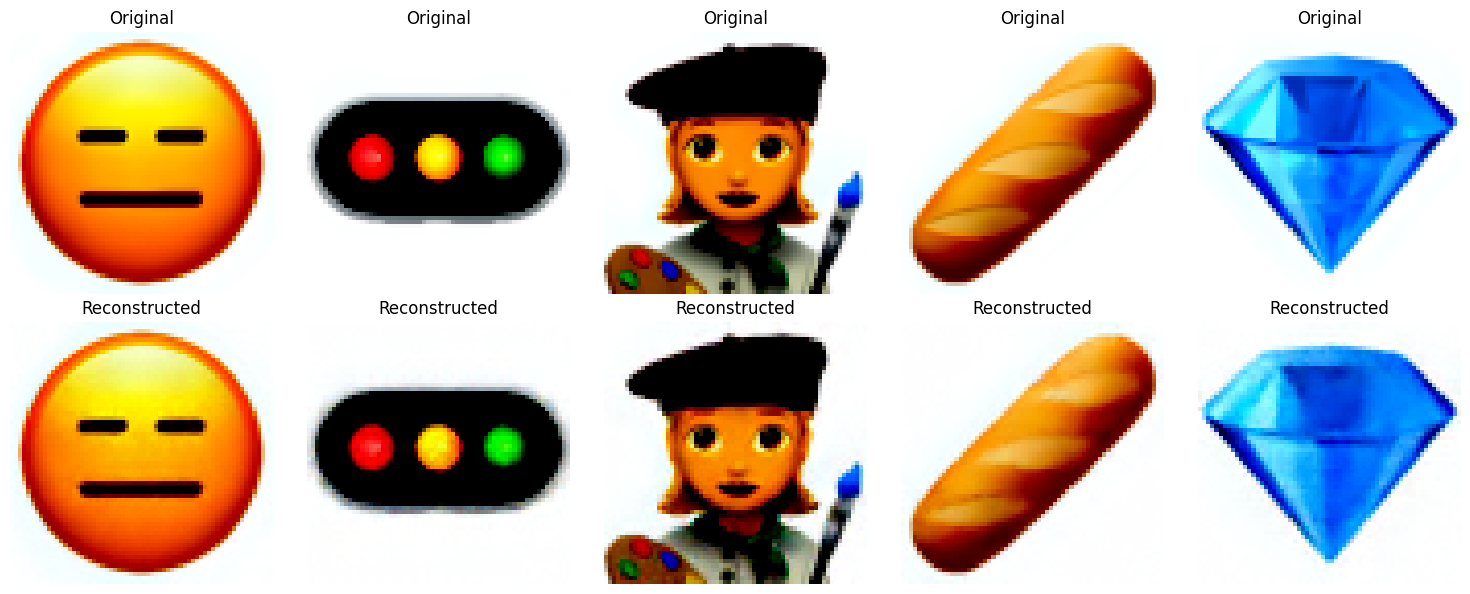

In [7]:
import matplotlib.pyplot as plt
import numpy as np


# Get a batch of images from the validation dataloader
dataiter = iter(validation_dataloader) # Use the validation dataloader
images = next(dataiter)['image'].to(device)

# Pass the images through the model to get reconstructions
with torch.no_grad():
    reconstructed_images, _ = vqvae(images)

# Convert tensors to numpy arrays for visualization
images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
reconstructed_images_np = reconstructed_images.cpu().numpy().transpose(0, 2, 3, 1)

# Clip the pixel values to the valid range [0, 1]
images_np = np.clip(images_np, 0, 1)
reconstructed_images_np = np.clip(reconstructed_images_np, 0, 1)

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(5):
    # Original images
    axes[0, i].imshow(images_np[i])
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Reconstructed images
    axes[1, i].imshow(reconstructed_images_np[i])
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Latent prior modelling

In [8]:
import torch
from tqdm import tqdm

top_codes = []
bottom_codes = []

with torch.no_grad():
    for batch in tqdm(train_dataloader):
        images = batch['image'].to(device)

        _, _, _, id_t, id_b = vqvae.encode(images)

        top_codes.append(id_t.cpu())
        bottom_codes.append(id_b.cpu())

all_top_codes = torch.cat(top_codes, dim=0)
all_bottom_codes = torch.cat(bottom_codes, dim=0)

print(f"Final shape of top codes: {all_top_codes.shape}")
print(f"Final shape of bottom codes: {all_bottom_codes.shape}")

torch.save({"top": all_top_codes, "bottom": all_bottom_codes}, "latent_codes.pt")

100%|██████████| 79/79 [00:08<00:00,  9.42it/s]

Final shape of top codes: torch.Size([2501, 8, 8])
Final shape of bottom codes: torch.Size([2501, 16, 16])


In [9]:
# Copyright (c) Xi Chen
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

# Borrowed from https://github.com/neocxi/pixelsnail-public and ported it to PyTorch

from math import sqrt
from functools import partial, lru_cache

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F


def wn_linear(in_dim, out_dim):
    return nn.utils.weight_norm(nn.Linear(in_dim, out_dim))


class WNConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
        activation=None,
    ):
        super().__init__()

        self.conv = nn.utils.weight_norm(
            nn.Conv2d(
                in_channel,
                out_channel,
                kernel_size,
                stride=stride,
                padding=padding,
                bias=bias,
            )
        )

        self.out_channel = out_channel

        if isinstance(kernel_size, int):
            kernel_size = [kernel_size, kernel_size]

        self.kernel_size = kernel_size

        self.activation = activation

    def forward(self, input):
        out = self.conv(input)

        if self.activation is not None:
            out = self.activation(out)

        return out


def shift_down(input, size=1):
    return F.pad(input, [0, 0, size, 0])[:, :, : input.shape[2], :]


def shift_right(input, size=1):
    return F.pad(input, [size, 0, 0, 0])[:, :, :, : input.shape[3]]


class CausalConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        stride=1,
        padding='downright',
        activation=None,
    ):
        super().__init__()

        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * 2

        self.kernel_size = kernel_size

        if padding == 'downright':
            pad = [kernel_size[1] - 1, 0, kernel_size[0] - 1, 0]

        elif padding == 'down' or padding == 'causal':
            pad = kernel_size[1] // 2

            pad = [pad, pad, kernel_size[0] - 1, 0]

        self.causal = 0
        if padding == 'causal':
            self.causal = kernel_size[1] // 2

        self.pad = nn.ZeroPad2d(pad)

        self.conv = WNConv2d(
            in_channel,
            out_channel,
            kernel_size,
            stride=stride,
            padding=0,
            activation=activation,
        )

    def forward(self, input):
        out = self.pad(input)

        if self.causal > 0:
            self.conv.conv.weight_v.data[:, :, -1, self.causal :].zero_()

        out = self.conv(out)

        return out


class GatedResBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        channel,
        kernel_size,
        conv='wnconv2d',
        activation=nn.ELU,
        dropout=0.1,
        auxiliary_channel=0,
        condition_dim=0,
    ):
        super().__init__()

        if conv == 'wnconv2d':
            conv_module = partial(WNConv2d, padding=kernel_size // 2)

        elif conv == 'causal_downright':
            conv_module = partial(CausalConv2d, padding='downright')

        elif conv == 'causal':
            conv_module = partial(CausalConv2d, padding='causal')

        self.activation = activation()
        self.conv1 = conv_module(in_channel, channel, kernel_size)

        if auxiliary_channel > 0:
            self.aux_conv = WNConv2d(auxiliary_channel, channel, 1)

        self.dropout = nn.Dropout(dropout)

        self.conv2 = conv_module(channel, in_channel * 2, kernel_size)

        if condition_dim > 0:
            # self.condition = nn.Linear(condition_dim, in_channel * 2, bias=False)
            self.condition = WNConv2d(condition_dim, in_channel * 2, 1, bias=False)

        self.gate = nn.GLU(1)

    def forward(self, input, aux_input=None, condition=None):
        out = self.conv1(self.activation(input))

        if aux_input is not None:
            out = out + self.aux_conv(self.activation(aux_input))

        out = self.activation(out)
        out = self.dropout(out)
        out = self.conv2(out)

        if condition is not None:
            condition = self.condition(condition)
            out += condition
            # out = out + condition.view(condition.shape[0], 1, 1, condition.shape[1])

        out = self.gate(out)
        out += input

        return out


@lru_cache(maxsize=64)
def causal_mask(size):
    shape = [size, size]
    mask = np.triu(np.ones(shape), k=1).astype(np.uint8).T
    start_mask = np.ones(size).astype(np.float32)
    start_mask[0] = 0

    return (
        torch.from_numpy(mask).unsqueeze(0),
        torch.from_numpy(start_mask).unsqueeze(1),
    )


class CausalAttention(nn.Module):
    def __init__(self, query_channel, key_channel, channel, n_head=8, dropout=0.1):
        super().__init__()

        self.query = wn_linear(query_channel, channel)
        self.key = wn_linear(key_channel, channel)
        self.value = wn_linear(key_channel, channel)

        self.dim_head = channel // n_head
        self.n_head = n_head

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key):
        batch, _, height, width = key.shape

        def reshape(input):
            return input.view(batch, -1, self.n_head, self.dim_head).transpose(1, 2)

        query_flat = query.view(batch, query.shape[1], -1).transpose(1, 2)
        key_flat = key.view(batch, key.shape[1], -1).transpose(1, 2)
        query = reshape(self.query(query_flat))
        key = reshape(self.key(key_flat)).transpose(2, 3)
        value = reshape(self.value(key_flat))

        attn = torch.matmul(query, key) / sqrt(self.dim_head)
        mask, start_mask = causal_mask(height * width)
        mask = mask.type_as(query)
        start_mask = start_mask.type_as(query)
        attn = attn.masked_fill(mask == 0, -1e4)
        attn = torch.softmax(attn, 3) * start_mask
        attn = self.dropout(attn)

        out = attn @ value
        out = out.transpose(1, 2).reshape(
            batch, height, width, self.dim_head * self.n_head
        )
        out = out.permute(0, 3, 1, 2)

        return out


class PixelBlock(nn.Module):
    def __init__(
        self,
        in_channel,
        channel,
        kernel_size,
        n_res_block,
        attention=True,
        dropout=0.1,
        condition_dim=0,
    ):
        super().__init__()

        resblocks = []
        for i in range(n_res_block):
            resblocks.append(
                GatedResBlock(
                    in_channel,
                    channel,
                    kernel_size,
                    conv='causal',
                    dropout=dropout,
                    condition_dim=condition_dim,
                )
            )

        self.resblocks = nn.ModuleList(resblocks)

        self.attention = attention

        if attention:
            self.key_resblock = GatedResBlock(
                in_channel * 2 + 2, in_channel, 1, dropout=dropout
            )
            self.query_resblock = GatedResBlock(
                in_channel + 2, in_channel, 1, dropout=dropout
            )

            self.causal_attention = CausalAttention(
                in_channel + 2, in_channel * 2 + 2, in_channel // 2, dropout=dropout
            )

            self.out_resblock = GatedResBlock(
                in_channel,
                in_channel,
                1,
                auxiliary_channel=in_channel // 2,
                dropout=dropout,
            )

        else:
            self.out = WNConv2d(in_channel + 2, in_channel, 1)

    def forward(self, input, background, condition=None):
        out = input

        for resblock in self.resblocks:
            out = resblock(out, condition=condition)

        if self.attention:
            key_cat = torch.cat([input, out, background], 1)
            key = self.key_resblock(key_cat)
            query_cat = torch.cat([out, background], 1)
            query = self.query_resblock(query_cat)
            attn_out = self.causal_attention(query, key)
            out = self.out_resblock(out, attn_out)

        else:
            bg_cat = torch.cat([out, background], 1)
            out = self.out(bg_cat)

        return out


class CondResNet(nn.Module):
    def __init__(self, in_channel, channel, kernel_size, n_res_block):
        super().__init__()

        blocks = [WNConv2d(in_channel, channel, kernel_size, padding=kernel_size // 2)]

        for i in range(n_res_block):
            blocks.append(GatedResBlock(channel, channel, kernel_size))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class PixelSNAIL(nn.Module):
    def __init__(
        self,
        shape,
        n_class,
        channel,
        kernel_size,
        n_block,
        n_res_block,
        res_channel,
        attention=True,
        dropout=0.1,
        n_cond_res_block=0,
        cond_res_channel=0,
        cond_res_kernel=3,
        n_out_res_block=0,
    ):
        super().__init__()

        height, width = shape

        self.n_class = n_class

        if kernel_size % 2 == 0:
            kernel = kernel_size + 1

        else:
            kernel = kernel_size

        self.horizontal = CausalConv2d(
            n_class, channel, [kernel // 2, kernel], padding='down'
        )
        self.vertical = CausalConv2d(
            n_class, channel, [(kernel + 1) // 2, kernel // 2], padding='downright'
        )

        coord_x = (torch.arange(height).float() - height / 2) / height
        coord_x = coord_x.view(1, 1, height, 1).expand(1, 1, height, width)
        coord_y = (torch.arange(width).float() - width / 2) / width
        coord_y = coord_y.view(1, 1, 1, width).expand(1, 1, height, width)
        self.register_buffer('background', torch.cat([coord_x, coord_y], 1))

        self.blocks = nn.ModuleList()

        for i in range(n_block):
            self.blocks.append(
                PixelBlock(
                    channel,
                    res_channel,
                    kernel_size,
                    n_res_block,
                    attention=attention,
                    dropout=dropout,
                    condition_dim=cond_res_channel,
                )
            )

        if n_cond_res_block > 0:
            self.cond_resnet = CondResNet(
                n_class, cond_res_channel, cond_res_kernel, n_cond_res_block
            )

        out = []

        for i in range(n_out_res_block):
            out.append(GatedResBlock(channel, res_channel, 1))

        out.extend([nn.ELU(inplace=True), WNConv2d(channel, n_class, 1)])

        self.out = nn.Sequential(*out)

    def forward(self, input, condition=None, cache=None):
        if cache is None:
            cache = {}
        batch, height, width = input.shape
        input = (
            F.one_hot(input, self.n_class).permute(0, 3, 1, 2).type_as(self.background)
        )
        horizontal = shift_down(self.horizontal(input))
        vertical = shift_right(self.vertical(input))
        out = horizontal + vertical

        background = self.background[:, :, :height, :].expand(batch, 2, height, width)

        if condition is not None:
            if 'condition' in cache:
                condition = cache['condition']
                condition = condition[:, :, :height, :]

            else:
                condition = (
                    F.one_hot(condition, self.n_class)
                    .permute(0, 3, 1, 2)
                    .type_as(self.background)
                )
                condition = self.cond_resnet(condition)
                condition = F.interpolate(condition, scale_factor=2)
                cache['condition'] = condition.detach().clone()
                condition = condition[:, :, :height, :]

        for block in self.blocks:
            out = block(out, background, condition=condition)

        out = self.out(out)

        return out, cache

In [10]:
from math import cos, pi, floor, sin

from torch.optim import lr_scheduler


class CosineLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (
            1 + cos(self.iteration / self.step_size * pi)
        )
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class PowerLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, warmup):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        if self.iteration < self.warmup:
            lr = (
                self.lr_min + (self.lr_max - self.lr_min) / self.warmup * self.iteration
            )

        else:
            lr = self.lr_max * (self.iteration - self.warmup + 1) ** -0.5

        self.iteration += 1

        return [lr for base_lr in self.base_lrs]


class SineLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = self.lr_min + (self.lr_max - self.lr_min) * sin(
            self.iteration / self.step_size * pi
        )
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class LinearLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, warmup, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        if self.iteration < self.warmup:
            lr = self.lr_max

        else:
            lr = self.lr_max + (self.iteration - self.warmup) * (
                self.lr_min - self.lr_max
            ) / (self.step_size - self.warmup)
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class CLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.epoch = 0
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.current_lr = lr_min
        self.step_size = step_size

        super().__init__(optimizer, -1)

    def get_lr(self):
        cycle = floor(1 + self.epoch / (2 * self.step_size))
        x = abs(self.epoch / self.step_size - 2 * cycle + 1)
        lr = self.lr_min + (self.lr_max - self.lr_min) * max(0, 1 - x)
        self.current_lr = lr

        self.epoch += 1

        return [lr for base_lr in self.base_lrs]


class Warmup(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, model_dim, factor=1, warmup=16000):
        self.optimizer = optimizer
        self.model_dim = model_dim
        self.factor = factor
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        self.iteration += 1
        lr = (
            self.factor
            * self.model_dim ** (-0.5)
            * min(self.iteration ** (-0.5), self.iteration * self.warmup ** (-1.5))
        )

        return [lr for base_lr in self.base_lrs]


# Copyright 2019 fastai

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Borrowed from https://github.com/fastai/fastai and changed to make it runs like PyTorch lr scheduler


class CycleAnnealScheduler:
    def __init__(
        self, optimizer, lr_max, lr_divider, cut_point, step_size, momentum=None
    ):
        self.lr_max = lr_max
        self.lr_divider = lr_divider
        self.cut_point = step_size // cut_point
        self.step_size = step_size
        self.iteration = 0
        self.cycle_step = int(step_size * (1 - cut_point / 100) / 2)
        self.momentum = momentum
        self.optimizer = optimizer

    def get_lr(self):
        if self.iteration > 2 * self.cycle_step:
            cut = (self.iteration - 2 * self.cycle_step) / (
                self.step_size - 2 * self.cycle_step
            )
            lr = self.lr_max * (1 + (cut * (1 - 100) / 100)) / self.lr_divider

        elif self.iteration > self.cycle_step:
            cut = 1 - (self.iteration - self.cycle_step) / self.cycle_step
            lr = self.lr_max * (1 + cut * (self.lr_divider - 1)) / self.lr_divider

        else:
            cut = self.iteration / self.cycle_step
            lr = self.lr_max * (1 + cut * (self.lr_divider - 1)) / self.lr_divider

        return lr

    def get_momentum(self):
        if self.iteration > 2 * self.cycle_step:
            momentum = self.momentum[0]

        elif self.iteration > self.cycle_step:
            cut = 1 - (self.iteration - self.cycle_step) / self.cycle_step
            momentum = self.momentum[0] + cut * (self.momentum[1] - self.momentum[0])

        else:
            cut = self.iteration / self.cycle_step
            momentum = self.momentum[0] + cut * (self.momentum[1] - self.momentum[0])

        return momentum

    def step(self):
        lr = self.get_lr()

        if self.momentum is not None:
            momentum = self.get_momentum()

        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        for group in self.optimizer.param_groups:
            group['lr'] = lr

            if self.momentum is not None:
                group['betas'] = (momentum, group['betas'][1])

        return lr


def anneal_linear(start, end, proportion):
    return start + proportion * (end - start)


def anneal_cos(start, end, proportion):
    cos_val = cos(pi * proportion) + 1

    return end + (start - end) / 2 * cos_val


class Phase:
    def __init__(self, start, end, n_iter, anneal_fn):
        self.start, self.end = start, end
        self.n_iter = n_iter
        self.anneal_fn = anneal_fn
        self.n = 0

    def step(self):
        self.n += 1

        return self.anneal_fn(self.start, self.end, self.n / self.n_iter)

    def reset(self):
        self.n = 0

    @property
    def is_done(self):
        return self.n >= self.n_iter


class CycleScheduler:
    def __init__(
        self,
        optimizer,
        lr_max,
        n_iter,
        momentum=(0.95, 0.85),
        divider=25,
        warmup_proportion=0.3,
        phase=('linear', 'cos'),
    ):
        self.optimizer = optimizer

        phase1 = int(n_iter * warmup_proportion)
        phase2 = n_iter - phase1
        lr_min = lr_max / divider

        phase_map = {'linear': anneal_linear, 'cos': anneal_cos}

        self.lr_phase = [
            Phase(lr_min, lr_max, phase1, phase_map[phase[0]]),
            Phase(lr_max, lr_min / 1e4, phase2, phase_map[phase[1]]),
        ]

        self.momentum = momentum

        if momentum is not None:
            mom1, mom2 = momentum
            self.momentum_phase = [
                Phase(mom1, mom2, phase1, phase_map[phase[0]]),
                Phase(mom2, mom1, phase2, phase_map[phase[1]]),
            ]

        else:
            self.momentum_phase = []

        self.phase = 0

    def step(self):
        lr = self.lr_phase[self.phase].step()

        if self.momentum is not None:
            momentum = self.momentum_phase[self.phase].step()

        else:
            momentum = None

        for group in self.optimizer.param_groups:
            group['lr'] = lr

            if self.momentum is not None:
                if 'betas' in group:
                    group['betas'] = (momentum, group['betas'][1])

                else:
                    group['momentum'] = momentum

        if self.lr_phase[self.phase].is_done:
            self.phase += 1

        if self.phase >= len(self.lr_phase):
            for phase in self.lr_phase:
                phase.reset()

            for phase in self.momentum_phase:
                phase.reset()

            self.phase = 0

        return lr, momentum


class LRFinder(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size, linear=False):
        ratio = lr_max / lr_min
        self.linear = linear
        self.lr_min = lr_min
        self.lr_mult = (ratio / step_size) if linear else ratio ** (1 / step_size)
        self.iteration = 0
        self.lrs = []
        self.losses = []

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = (
            self.lr_mult * self.iteration
            if self.linear
            else self.lr_mult ** self.iteration
        )
        lr = self.lr_min + lr if self.linear else self.lr_min * lr

        self.iteration += 1
        self.lrs.append(lr)

        return [lr for base_lr in self.base_lrs]

    def record(self, loss):
        self.losses.append(loss)

    def save(self, filename):
        with open(filename, 'w') as f:
            for lr, loss in zip(self.lrs, self.losses):
                f.write('{},{}\n'.format(lr, loss))

In [11]:
from torch.utils.data import Dataset, DataLoader
class LatentCodeDataset(Dataset):
    def __init__(self, path_to_codes):
        data = torch.load(path_to_codes)
        self.top = data['top']
        self.bottom = data['bottom']
        print(f"Loaded {len(self.top)} latent code pairs from '{path_to_codes}'.")

    def __len__(self):
        return self.top.shape[0]

    def __getitem__(self, index):
        return self.top[index], self.bottom[index], 0

In [12]:
import torch
from torch import nn
from tqdm.notebook import tqdm

def train_model(config, model, loader, optimizer, scheduler, device):
    criterion = nn.CrossEntropyLoss()
    loss = float('inf')
    for epoch in range(config["epochs"]):
        total_loss = 0.0
        total_accuracy = 0.0
        
        loop = tqdm(loader, desc=f"Epoch [{epoch+1}/{config['epochs']}]")
        
        for i, (top, bottom, label) in enumerate(loop):
            model.zero_grad()
            top = top.to(device)

            if config["hier"] == 'top':
                target = top
                out, _ = model(top)
            elif config["hier"] == 'bottom':
                bottom = bottom.to(device)
                target = bottom
                out, _ = model(bottom, condition=top)

            loss = criterion(out, target)
            loss.backward()

            if scheduler is not None:
                scheduler.step()
            optimizer.step()

            _, pred = out.max(1)
            accuracy = (pred == target).float().mean()
            
            total_loss += loss.item()
            total_accuracy += accuracy.item()
            
            loop.set_postfix(loss=loss.item(), acc=accuracy.item())

        avg_epoch_loss = total_loss / len(loader)
        avg_epoch_accuracy = total_accuracy / len(loader)
        
        print(f"Epoch [{epoch+1}/{config['epochs']}] Summary:")
        print(f"  -> Average Loss: {avg_epoch_loss:.4f}")
        print(f"  -> Average Accuracy: {avg_epoch_accuracy:.4f}\n")
        
        if avg_epoch_loss < loss:
            model_state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            save_path = f"pixelsnail_{config['hier']}.pt"
            torch.save(model_state, save_path)
            loss = avg_epoch_loss

In [13]:
# config = {
#     "path": "latent_codes.pt",
#     "hier": "top",
#     "batch_size": 16,
#     "epochs": 150,
#     "learning_rate": 3e-4,

#     "top_code_shape": [8, 8],
#     "bottom_code_shape": [16, 16],
#     "n_class": 64,

#     "channel": 128,
#     "n_res_block": 2,
#     "n_res_channel": 128,
#     "n_out_res_block": 0,
#     "n_cond_res_block": 2,  
#     "dropout": 0.1,
# }

config = {
    "path": "latent_codes.pt",
    "hier": "top",
    "batch_size": 32,
    
    "epochs": 200,
    "learning_rate": 3e-4,
    
    "top_code_shape": [8, 8],
    "n_class": 512,          
    "channel": 128,          
    "n_res_block": 3,
    "n_res_channel": 128, 
    "n_out_res_block": 1,  
    "dropout": 0.1, 
    "attention": True,  
    
}

In [14]:
dataset = LatentCodeDataset(config["path"])
loader = DataLoader(
    dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4, drop_last=True
)

Loaded 2501 latent code pairs from 'latent_codes.pt'.


In [15]:
def main(config):
    if config["hier"] == 'top':
        model = PixelSNAIL(
            shape=config["top_code_shape"], n_class=config["n_class"],
            channel=config["channel"], kernel_size=5, n_block=4,
            n_res_block=config["n_res_block"], res_channel=config["n_res_channel"],
            dropout=config["dropout"], n_out_res_block=config["n_out_res_block"],
        )
    elif config["hier"] == 'bottom':
        model = PixelSNAIL(
            shape=config["bottom_code_shape"], n_class=config["n_class"],
            channel=config["channel"], kernel_size=5, n_block=4,
            n_res_block=config["n_res_block"], res_channel=config["n_res_channel"],
            attention=False, dropout=config["dropout"],
            n_cond_res_block=config["n_cond_res_block"],
            cond_res_channel=config["n_res_channel"],
        )
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model) 
    
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = CycleScheduler(optimizer, config["learning_rate"], n_iter=len(loader) * config["epochs"])
    
    final_model_path = f"pixelsnail_{config['hier']}_final.pt"
    train_model(config, model, loader, optimizer, scheduler, device)

    print("Training finished")
    
    model_state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    torch.save(model_state, final_model_path)
    print(f"Final model saved to '{final_model_path}'")

In [16]:
import torch.optim as optim
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
bottom_config = {
    "path": "latent_codes.pt",
    "hier": "bottom",
    "batch_size": 16,              # bottom is larger
    
    # Training
    "epochs": 200,                 # Increased from 150
    "learning_rate": 3e-4,         # Good
    
    # Architecture - More complex since 512 codes fully used
    "top_code_shape": [8, 8],      # For conditioning
    "bottom_code_shape": [16, 16], # 256 positions
    "n_class": 512,                # Must match n_embed
    "channel": 256,                # INCREASED for bottom complexity
    "n_res_block": 4,              # Increased from 2
    "n_res_channel": 256,          # INCREASED
    "n_out_res_block": 2,          # Increased from 0
    "n_cond_res_block": 3,         # Increased from 2 (for top conditioning)
    "dropout": 0.1,                # Good
}

In [18]:
model_top = PixelSNAIL(
            shape=config["top_code_shape"], n_class=config["n_class"],
            channel=config["channel"], kernel_size=5, n_block=4,
            n_res_block=config["n_res_block"], res_channel=config["n_res_channel"],
            dropout=config["dropout"], n_out_res_block=config["n_out_res_block"],
        )

config = bottom_config
model_bottom = PixelSNAIL(
    shape=config["bottom_code_shape"], n_class=config["n_class"],
    channel=config["channel"], kernel_size=5, n_block=4,
    n_res_block=config["n_res_block"], res_channel=config["n_res_channel"],
    attention=False, dropout=config["dropout"],
    n_cond_res_block=config["n_cond_res_block"],
    cond_res_channel=config["n_res_channel"],
)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [19]:
model_top.load_state_dict(torch.load('/kaggle/input/pixelsnail/pytorch/default/1/pixelsnail_top_final (1).pt'))
model_bottom.load_state_dict(torch.load('/kaggle/input/pixelsnail/pytorch/default/1/pixelsnail_bottom (1).pt'))

<All keys matched successfully>

In [20]:
model_top.eval()
model_bottom.eval()
model_vqvae = vqvae
model_vqvae.eval()

VQVAE(
  (enc_b): Encoder(
    (blocks): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (6): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (7): ResBlock(
        (conv): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 128, ker

In [21]:
import torch
from torchvision.utils import save_image
from tqdm import tqdm



@torch.no_grad()
def sample_model(model, device, batch, size, temperature, condition=None):
    row = torch.zeros(batch, *size, dtype=torch.int64).to(device)
    cache = {}

    for i in tqdm(range(size[0])):
        for j in range(size[1]):
            out, cache = model(row[:, : i + 1, :], condition=condition, cache=cache)
            prob = torch.softmax(out[:, :, i, j] / temperature, 1)
            sample = torch.multinomial(prob, 1).squeeze(-1)
            row[:, i, j] = sample

    return row



batch = 4
temp = 0.6
filename = 'sample.png'
device = 'cuda'


top_sample = sample_model(model_top, device, batch, [8, 8], temp)

bottom_sample = sample_model(
    model_bottom, device, batch, [16, 16], temp, condition=top_sample
)

decoded_sample = model_vqvae.decode_code(top_sample, bottom_sample)
decoded_sample = decoded_sample.clamp(-1, 1)

save_image(decoded_sample, filename, normalize=True)

100%|██████████| 16/16 [02:32<00:00,  9.52s/it]


In [22]:
import tempfile

def calculate_fid(original_images_list, reconstructed_images_list, device):
    """
    Calculates FID between original and reconstructed images.

    Args:
        original_images_list (list): List of original image tensors (N, C, H, W).
        reconstructed_images_list (list): List of reconstructed image tensors (N, C, H, W).
        device (torch.device): The device.

    Returns:
        float: The FID value.
    """
    # Create temporary directories to store original and reconstructed images
    with tempfile.TemporaryDirectory() as original_dir, \
         tempfile.TemporaryDirectory() as reconstructed_dir:

        # Iterate through the image lists and save images
        for i, (original_batch, reconstructed_batch) in enumerate(zip(original_images_list, reconstructed_images_list)):
            for j in range(original_batch.shape[0]):
                 # Denormalize images before saving for FID calculation
                original_img = original_batch[j] * 0.5 + 0.5
                reconstructed_img = reconstructed_batch[j] * 0.5 + 0.5

                save_image(original_img, os.path.join(original_dir, f"original_{i}_{j}.png"))
                save_image(reconstructed_img, os.path.join(reconstructed_dir, f"reconstructed_{i}_{j}.png"))


        # Calculate FID using torch-fidelity
        metrics_dict = torch_fidelity.calculate_metrics(
            input1=original_dir,
            input2=reconstructed_dir,
            cuda=device.type == 'cuda',
            isc=False,
            fid=True,
            kid=False,
            prdc=False,
        )

        return metrics_dict['frechet_inception_distance']


In [23]:
!pip install torch-fidelity

In [24]:
import os
import torch_fidelity

device = torch.device('cuda')
batch = 4
temp = 0.5

# Generate samples
top_sample = sample_model(model_top, device, batch, [8, 8], temp)
bottom_sample = sample_model(model_bottom, device, batch, [16, 16], temp, condition=top_sample)
decoded_sample = model_vqvae.decode_code(top_sample, bottom_sample).clamp(-1, 1)

# Reconstruct from real dataset for comparison
# (Example: take real images from your validation loader)
original_images_list = []
reconstructed_images_list = []

for batch in validation_dataloader:
    # Check the right key — adjust depending on your dataset
    if isinstance(batch, dict):
        if "pixel_values" in batch:
            real_images = batch["pixel_values"].to(device)
        elif "image" in batch:
            real_images = batch["image"].to(device)
        else:
            raise KeyError(f"Unknown batch keys: {batch.keys()}")
    else:
        real_images = batch.to(device)

    with torch.no_grad():
        reconstructed = model_vqvae(real_images)[0].clamp(-1, 1)

    original_images_list.append(real_images.cpu())
    reconstructed_images_list.append(reconstructed.cpu())


# Compute FID between original and reconstructed sets
fid_value = calculate_fid(original_images_list, reconstructed_images_list, device)
print(f"FID score: {fid_value:.4f}")


100%|██████████| 16/16 [02:20<00:00,  8.76s/it]
Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/tmp/tmp_lyk38z_" with extensions png,jpg,jpeg
Found 248 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                         
Extracting statistics from input 2
Looking for samples non-recursivelty in "/tmp/tmpqzce3z4x" with extensions png,jpg,jpeg
Found 248 samples
Processing samples                                                      

FID score: 33.3787


Frechet Inception Distance: 33.378685266973434


In [25]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00


In [26]:
import torch
import lpips

@torch.no_grad()
def calculate_lpips(original_images_list, reconstructed_images_list, device):
    """
    Calculates average LPIPS between original and reconstructed images.
    
    Args:
        original_images_list (list[Tensor]): list of (N, C, H, W) tensors in [-1, 1].
        reconstructed_images_list (list[Tensor]): same shape as originals.
        device (torch.device): CUDA or CPU.
    
    Returns:
        float: mean LPIPS score (lower is better)
    """
    loss_fn = lpips.LPIPS(net='vgg').to(device)
    total_score = 0.0
    count = 0

    for orig_batch, recon_batch in zip(original_images_list, reconstructed_images_list):
        orig_batch = orig_batch.to(device)
        recon_batch = recon_batch.to(device)

        # LPIPS expects tensors in [-1, 1]
        for i in range(orig_batch.shape[0]):
            score = loss_fn(orig_batch[i].unsqueeze(0), recon_batch[i].unsqueeze(0))
            total_score += score.item()
            count += 1

    return total_score / count


In [27]:
lpips_value = calculate_lpips(original_images_list, reconstructed_images_list, device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 56.5MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


In [28]:
print(f"LPIPS: {lpips_value:.4f}")

LPIPS: 0.0278
